In [1]:
import torch
import os
import sys
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights
from torchvision.transforms.functional import normalize
from tqdm import tqdm
from torchvision.transforms import v2
from IPython.display import clear_output

sys.path.append(os.path.join(os.getcwd(), "../uzk_cvproject"))
from fly_dataset import FLY_Dataset
from fly_resnet import FLY_Resnet  # oder dein Modell
from fly_training_bumblebee import train_keypoint_model  # deine Trainingsfunktion
from fly_visualizer import visualize_fly_batch #visualize_fly, visualize_fly_with_limbs, 
#from fly_evaluate import fly_evaluate_and_visualize, fly_eval

# Pfad zum Datensatz
DATA_PATH = "/scratch/cv-course2025/group2/data"

In [2]:
# Dataset laden
train_dataset = FLY_Dataset(DATA_PATH, mode="training", backbone="resnet")

# Modell initialisieren
model = FLY_Resnet(num_joints=38)

# CUDA/CPU auswählen
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
trained_model_1 = FLY_Resnet()
trained_model_1.load_state_dict(torch.load("/scratch/cv-course2025/group2/uzk_cvproject/models/deep-fly-model-resnet50_20250706-051753.pt"))
trained_model_1.to(device)
print("model 1 loaded")
print(trained_model_1.training)

trained_model_2 = FLY_Resnet()
trained_model_2.load_state_dict(torch.load("/scratch/cv-course2025/group2/uzk_cvproject/models/deep-fly-model-resnet50_20250706-175105.pt"))
trained_model_2.to(device)
print("model 2 loaded")

test_dataset = FLY_Dataset(DATA_PATH, mode="test", backbone="resnet", cam=0)

model 1 loaded
True
model 2 loaded


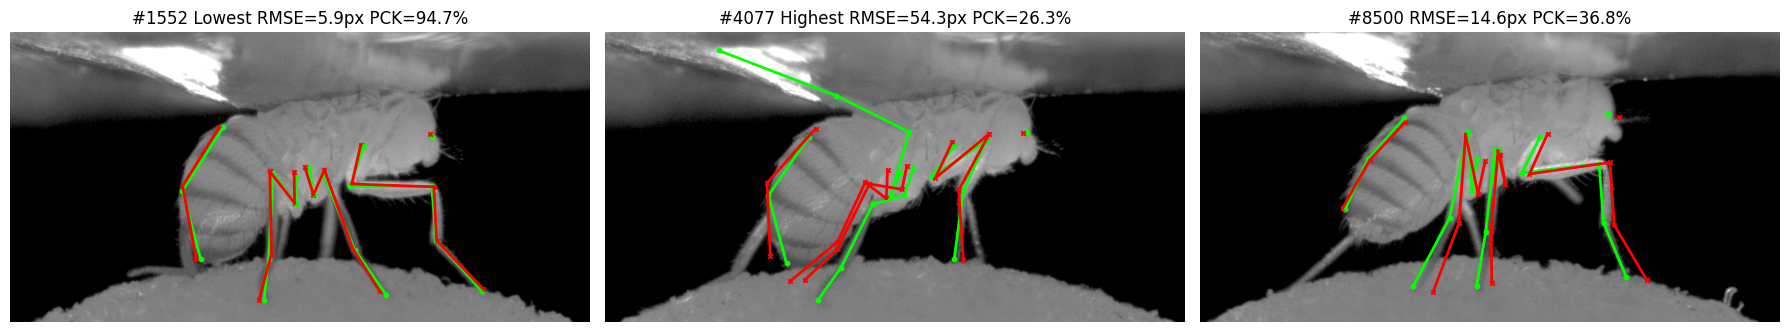

Evaluating: 100%|███████████████████████████████████████████████| 9000/9000 [01:53<00:00, 79.53it/s]


Results:  MSE=270.69px²,  RMSE=12.61px,  PCK@10px=47.43%


(270.6897570245531, 12.61020148038864, 0.4742982456140351)

In [17]:
def fly_eval2(
    model,
    dataset,
    device="cuda:0",
    pck_thresh=10,          # now interpreted in pixels
    visualize_every=500
):
    model.eval()

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    H, W = dataset.H, dataset.W
    scale = torch.tensor([H, W], dtype=torch.float32, device=device)
    
    total_mse     = 0.0
    total_rmse    = 0.0
    total_correct = 0
    total_visible = 0

    min_euc = 256
    max_euc = 0
    
    extr_images, extr_gts, extr_preds, extr_vis, extr_titles = [None] * 3, [None] * 3, [None] * 3, [None] * 3, [None] * 3

    for i in tqdm(range(len(dataset)), desc="Evaluating", ncols=100):
        img, keypts, visible = dataset[i]

        #normalize & batch→device
        
        gt  = keypts.to(device)                                 # [J,2] normalized
        mask= visible.to(device)
        test_img = img.to(device).unsqueeze(0)
        test_img = normalize(test_img, mean=mean, std=std)      # [1, 3, H, W] on CUDA
        with torch.no_grad():
            pred_b = model(test_img)                # [J,2] normalized
        pred = pred_b.squeeze(0)
        # # --- convert to pixel coords ---
        pred_px = pred * scale
        gt_px   = gt   * scale

        diff    = pred_px[mask] - gt_px[mask]
        sq_err  = diff.pow(2).sum(dim=1)                  
        euc     = sq_err.sqrt()                              

        n_vis   = mask.sum().item()
        if n_vis == 0:
            continue

        # accumulate
        total_mse     += sq_err.mean().item()  * n_vis
        total_rmse    += euc.mean().item()     * n_vis
        total_correct += (euc < pck_thresh).sum().item()
        total_visible += n_vis

        if min_euc > euc.mean().item():
            title = f"#{i} Lowest RMSE={euc.mean().item():.1f}px PCK={100*(euc< pck_thresh).float().mean().item():.1f}%"
            extr_images[0] = test_img.cpu().squeeze(0)
            extr_gts[0] = keypts
            extr_preds[0] = pred
            extr_vis[0] = visible
            extr_titles[0] = title
            min_euc = euc.mean().item()

        if max_euc < euc.mean().item():
            title = f"#{i} Highest RMSE={euc.mean().item():.1f}px PCK={100*(euc< pck_thresh).float().mean().item():.1f}%"
            extr_images[1] = test_img.cpu().squeeze(0)
            extr_gts[1] = keypts
            extr_preds[1] = pred
            extr_vis[1] = visible
            extr_titles[1] = title
            max_euc = euc.mean().item()


        # visualize
        if i % visualize_every == 0:
            title = f"#{i} RMSE={euc.mean().item():.1f}px PCK={100*(euc< pck_thresh).float().mean().item():.1f}%"
            extr_images[2] = test_img.cpu().squeeze(0)
            extr_gts[2] = keypts
            extr_preds[2] = pred
            extr_vis[2] = visible
            extr_titles[2] = title

            clear_output(wait=True)
            visualize_fly_batch(extr_images, extr_gts, extr_preds, extr_vis, extr_titles)

    # averages
    mean_mse  = total_mse  / total_visible
    mean_rmse = total_rmse / total_visible
    mean_pck  = total_correct / total_visible

    print(f"\nResults:  MSE={mean_mse:.2f}px²,  RMSE={mean_rmse:.2f}px,  PCK@{pck_thresh}px={mean_pck*100:.2f}%")
    return mean_mse, mean_rmse, mean_pck

fly_eval2(trained_model_2, test_dataset, device=device, pck_thresh=10)
